## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [3]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file
with open('complaints.json', 'r') as f:
	# returns JSON object as a dictionary
	data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [21]:
df.shape

(78313, 22)

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign new column names
df.columns = [
    'index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue',
    'date_received', 'state', 'consumer_disputed', 'product', 'company_response',
    'company', 'submitted_via', 'date_sent_to_company', 'company_public_response',
    'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'
]

In [8]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [17]:
(df['complaint_what_happened'].str.strip() == '').sum()

np.int64(57241)

In [18]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [19]:
(df['complaint_what_happened'].str.strip() == '').sum()

np.int64(0)

In [20]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [23]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]

In [24]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [25]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re
import string

def clean_complaint_text(text):
    if pd.isnull(text):
        return text  # Skip null values
    
    # 1. Make text lowercase
    text = text.lower()
    
    # 2. Remove text inside square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # 5. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [29]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    cleaned_text = clean_complaint_text(text)
    if pd.isnull(cleaned_text):
        return text
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [30]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame({
    'complaint_what_happened': df['complaint_what_happened'],
    'lemmatized_complaint': df['complaint_what_happened'].apply(lemmatize_text)
})

In [31]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my XXXX XXXX card in XX / XX/2018 an...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a XXXX x..."
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my..."
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with XXXX pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yr . I have...


In [32]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  doc = nlp(text)
  return ' '.join([token.text for token in doc if token.pos_ == "NOUN"])



# df_clean["complaint_POS_removed"] =  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(pos_tag)


In [33]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX xxxx and I apprec...,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my XXXX XXXX card in XX / XX/2018 an...,XXXX card XX/2018 agent anniversary date agent...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,report application identity consent service cr...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a XXXX x...",ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit XXX...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with XXXX pay and do not und...,risk consumer bank app year banking merchant m...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yr . I have...,credit yr credit card problem balance transfer...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




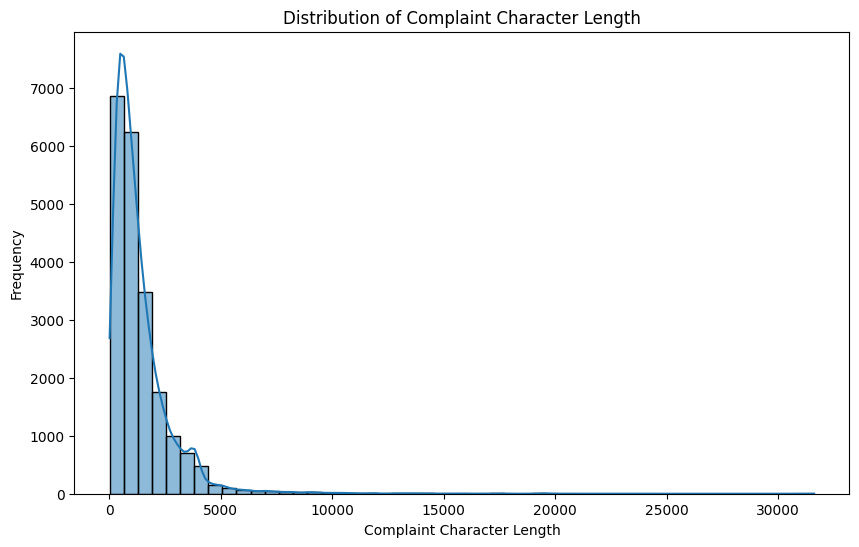

In [37]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
plt.figure(figsize=(10,6))
sns.histplot(df_clean['complaint_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Character Length')
plt.xlabel('Complaint Character Length')
plt.ylabel('Frequency')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

Top 40 Words by Frequency:
account: 46854
credit: 30373
card: 27916
XXXX: 25781
payment: 20859
bank: 17582
time: 16034
charge: 14754
day: 13159
money: 11895
check: 10983
loan: 10208
information: 9561
letter: 9477
fee: 8576
number: 8540
month: 8504
report: 8480
transaction: 8421
year: 8405
amount: 8309
call: 7912
phone: 7560
balance: 7555
customer: 7456
company: 7391
fund: 6972
mortgage: 6911
claim: 6703
state: 6619
chase: 6598
issue: 6511
service: 6413
date: 6173
fraud: 5799
email: 5626
dispute: 5610
business: 5295
interest: 5231
statement: 5196


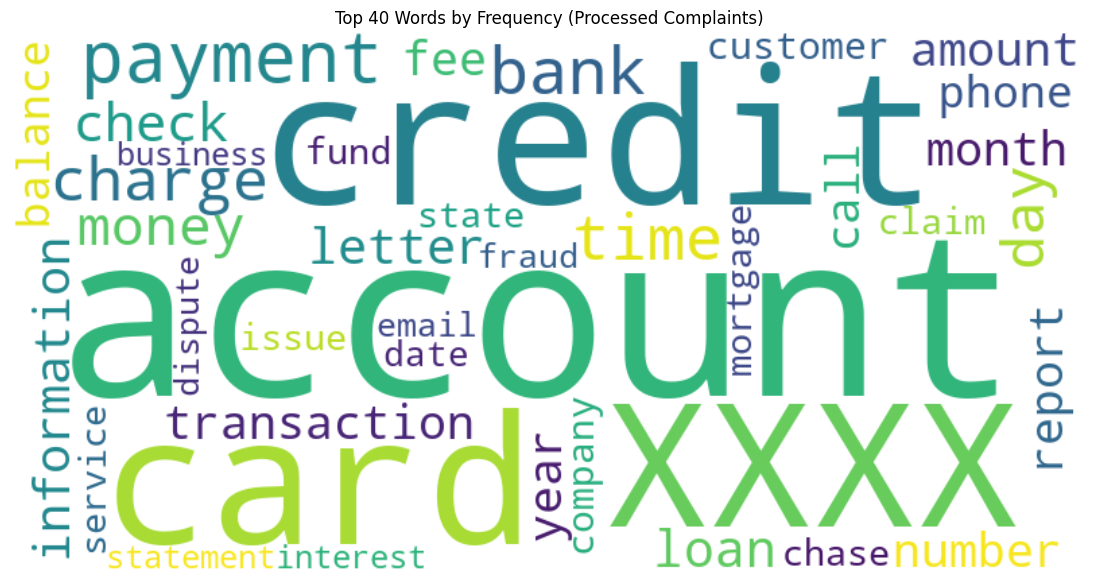

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all processed complaints into one string
all_words = ' '.join(df_clean['complaint_POS_removed'].dropna()).split()

# Count word frequencies
word_freq = Counter(all_words)

# Get the top 40 words
top_40_words = word_freq.most_common(40)

# Display the top 40 words with their counts
print("Top 40 Words by Frequency:")
for word, freq in top_40_words:
    print(f"{word}: {freq}")

# Generate the word cloud for top 40 words
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white')
wordcloud = wordcloud.generate_from_frequencies(dict(top_40_words))

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 40 Words by Frequency (Processed Complaints)')
plt.show()


In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [44]:
from collections import Counter

#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
# Get the top 30 unigrams by frequency
top_30_unigrams = Counter(all_words).most_common(30)

# Display the top 30 unigrams with their counts
print("Top 30 Unigrams by Frequency:")
for word, freq in top_30_unigrams:
    print(f"{word}: {freq}")

Top 30 Unigrams by Frequency:
account: 46854
credit: 30373
card: 27916
XXXX: 25781
payment: 20859
bank: 17582
time: 16034
charge: 14754
day: 13159
money: 11895
check: 10983
loan: 10208
information: 9561
letter: 9477
fee: 8576
number: 8540
month: 8504
report: 8480
transaction: 8421
year: 8405
amount: 8309
call: 7912
phone: 7560
balance: 7555
customer: 7456
company: 7391
fund: 6972
mortgage: 6911
claim: 6703
state: 6619


In [46]:
#Print the top 10 words in the unigram frequency
for word, freq in top_30_unigrams[:10]:
    print(f"{word}: {freq}")

account: 46854
credit: 30373
card: 27916
XXXX: 25781
payment: 20859
bank: 17582
time: 16034
charge: 14754
day: 13159
money: 11895


In [48]:
from collections import Counter

#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
# Generate bigrams from all_words
bigrams = zip(all_words, all_words[1:])
bigram_list = [' '.join(bigram) for bigram in bigrams]

# Get the top 30 bigrams by frequency
top_30_bigrams = Counter(bigram_list).most_common(30)

# Display the top 30 bigrams with their counts
print("Top 30 Bigrams by Frequency:")
for bigram, freq in top_30_bigrams:
    print(f"{bigram}: {freq}")

Top 30 Bigrams by Frequency:
credit card: 11269
XXXX XXXX: 3784
credit report: 3739
account account: 2671
customer service: 2622
checking account: 2533
bank account: 2289
debit card: 1841
card account: 1650
phone call: 1649
credit score: 1648
account credit: 1592
money account: 1372
payment payment: 1357
check account: 1294
interest rate: 1290
business day: 1252
phone number: 1246
card card: 1222
charge account: 1167
account bank: 1150
account XXXX: 1105
account number: 1089
card company: 1039
mortgage payment: 1026
credit account: 993
card credit: 975
fund account: 967
police report: 943
payment account: 931


In [49]:
#Print the top 10 words in the bigram frequency
for word, freq in top_30_bigrams[:10]:
    print(f"{word}: {freq}")

credit card: 11269
XXXX XXXX: 3784
credit report: 3739
account account: 2671
customer service: 2622
checking account: 2533
bank account: 2289
debit card: 1841
card account: 1650
phone call: 1649


In [50]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
# Generate trigrams from all_words
trigrams = zip(all_words, all_words[1:], all_words[2:])
trigram_list = [' '.join(trigram) for trigram in trigrams]

# Get the top 30 trigrams by frequency
top_30_trigrams = Counter(trigram_list).most_common(30)

# Display the top 30 trigrams with their counts
print("Top 30 Trigrams by Frequency:")
for trigram, freq in top_30_trigrams:
    print(f"{trigram}: {freq}")

Top 30 Trigrams by Frequency:
credit card account: 1040
XXXX XXXX XXXX: 1017
credit card company: 886
account credit card: 520
inquiry credit report: 497
credit card credit: 494
charge credit card: 470
card credit card: 416
credit report credit: 326
customer service representative: 316
credit reporting agency: 313
chase credit card: 295
credit card charge: 291
credit card payment: 277
payment credit card: 275
account credit report: 275
XXXX credit card: 270
credit card card: 264
credit card balance: 243
victim identity theft: 222
credit card XXXX: 208
interest rate %: 206
account account account: 203
letter date XXXX: 199
credit card statement: 197
credit card year: 196
credit card number: 182
credit card bank: 182
report credit report: 179
account bank account: 178


In [51]:
#Print the top 10 words in the trigram frequency
for word, freq in top_30_trigrams[:10]:
    print(f"{word}: {freq}")

credit card account: 1040
XXXX XXXX XXXX: 1017
credit card company: 886
account credit card: 520
inquiry credit report: 497
credit card credit: 494
charge credit card: 470
card credit card: 416
credit report credit: 326
customer service representative: 316


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [52]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [53]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX xxxx and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my XXXX XXXX card in XX / XX/2018 an...,XXXX card XX/2018 agent anniversary date agent...,355,XXXX card XX/2018 agent anniversary date agent...
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,report application identity consent service cr...,224,report application identity consent service cr...
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a XXXX x...",ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a Chase Card customer for well over a...,customer decade solicitation credit card bonus...,679,customer decade solicitation credit card bonus...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","on Wednesday , XX / XX / XXXX I call Chas , my...",provider claim purchase protection benefit XXX...,2114,provider claim purchase protection benefit XXX...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with XXXX pay and do not und...,risk consumer bank app year banking merchant m...,2319,risk consumer bank app year banking merchant m...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for 30 yr . I have...,credit yr credit card problem balance transfer...,2171,credit yr credit card problem balance transfer...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [54]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [56]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [57]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40)

In [61]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6376

In [62]:
#Print the Top15 words for each of the topics
# Print the Top15 words for each topic
feature_names = tfidf.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx}:")
    top_indices = topic.argsort()[::-1][:15]
    top_words = [feature_names[i] for i in top_indices]
    print(", ".join(top_words))
    print()

Topic #0:
account, check, bank, money, fund, deposit, day, branch, checking, number, chase, business, transaction, transfer, xxxx

Topic #1:
credit, card, report, inquiry, account, score, company, limit, information, chase, application, debt, letter, year, balance

Topic #2:
payment, balance, month, fee, statement, time, day, mortgage, auto, xxxx, date, credit, year, pay, account

Topic #3:
charge, card, fee, transaction, dispute, xxxx, merchant, purchase, claim, fraud, service, statement, time, email, refund

Topic #4:
loan, mortgage, xxxx, home, modification, property, letter, year, document, time, rate, foreclosure, house, information, request



In [63]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

df_clean['Topic'] = nmf_model.transform(dtm).argmax(axis=1)

In [67]:
#Assign the best topic to each of the cmplaints in Topic Column

# df_clean['Topic'] = #write your code to assign topics to each rows.
df_clean['Topic'] = nmf_model.transform(dtm).argmax(axis=1)

In [68]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX xxxx and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my XXXX XXXX card in XX / XX/2018 an...,XXXX card XX/2018 agent anniversary date agent...,355,XXXX card XX/2018 agent anniversary date agent...,4
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,report application identity consent service cr...,224,report application identity consent service cr...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a XXXX x...",ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,1
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0


In [69]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX xxxx and I apprec...,morning name stop cardmember service debt veri...,486,morning name stop cardmember service debt veri...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund chase bank account mone...,477,son chase account fund chase bank account mone...,0
17,With out notice J.P. Morgan Chase restricted m...,with out notice J.P. Morgan Chase restrict my ...,notice account debit card branch customer serv...,2277,notice account debit card branch customer serv...,0
24,mishandling of this account by Chase auto and ...,mishandle of this account by Chase auto and XX...,mishandle account auto,51,mishandle account auto,0
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on XXXX and ...,account bank code bonus term account deposit b...,413,account bank code bonus term account deposit b...,0
11,"On XX/XX/2018, while trying to book a XXXX XX...","on XX / XX/2018 , while try to book a XXXX x...",ticket offer ticket reward card information of...,1502,ticket offer ticket reward card information of...,1
15,Can you please remove inquiry,can you please remove inquiry,inquiry,29,inquiry,1
10,Chase Card was reported on XX/XX/2019. However...,Chase Card be report on XX / XX/2019 . however...,report application identity consent service cr...,224,report application identity consent service cr...,1
26,I have reached out to XXXX several times in at...,I have reach out to XXXX several time in attem...,time attempt inquiry remove creditor inquiry r...,753,time attempt inquiry remove creditor inquiry r...,1
23,I have a Chase credit card which is incorrectl...,I have a Chase credit card which be incorrectl...,credit card report datum credit report company...,129,credit card report datum credit report company...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



